## **Table of Contents**

1.  Creating a test problem, the objective function
2.  Surrogate Function Technique to minimize the objective using Tree-Structured Parzen Estimator
3.  Acquisition Function
4.  Running the Bayesian Optimization Algorithm - SMBO (Sequential Model Based Optimisation)
    -   Evaluating Trials and Objectives (Comparison of Results)
5.  Domain space identification
6.  Building the loss and status metric


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Creating the test problem

In [3]:
#objective function to minimize

def objective(x):
    f = np.poly1d([1,-2, -28, 28, 12, -26, 100])
    return f(x) *0.05 #returning the value of the polynomial

Min of -219.8012 occurs at 4.8779


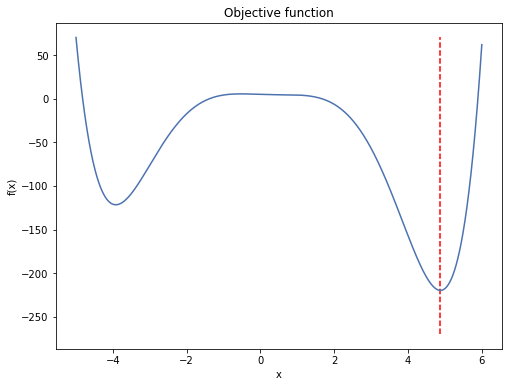

In [4]:
#space over which to evaluate the function
x = np.linspace(-5,6,10000)
y = objective(x)
min_y = min(y)
min_x = x[np.argmin(y)]

#plotting the data
plt.figure(figsize = (8,6))
plt.style.use('seaborn-deep')
plt.title('Objective function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.vlines(min_x, min(y)-50, max(y), linestyle = '--', colors = 'r')
plt.plot(x,y);

print('Min of %0.4f occurs at %0.4f' %(min(y),min_x))

# 2. Surrogate Function / Domain

The values of x over which we evaluate the function.

In [5]:
from hyperopt import hp

#creating the domain space for evaluation
space = hp.uniform('x', -4, 6)

print(space)

0 float
1   hyperopt_param
2     Literal{x}
3     uniform
4       Literal{-4}
5       Literal{6}


Text(0, 0.5, 'frequency')

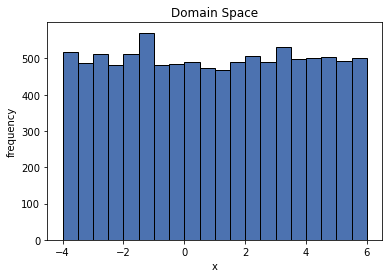

In [6]:
#visualising the ditribution using hyper opt
from hyperopt.pyll.stochastic import sample

samples = []

for _ in range(10000):
    samples.append(sample(space))

#histogram
plt.hist(samples, bins = 20,edgecolor = 'black')
plt.title('Domain Space')
plt.xlabel('x')
plt.ylabel('frequency')

The algorithm will sample values from this distribution. With Bayesian optimization it would focus more around the global minima of 4.9 as indicated above.

# 4.  Hyper Parameter Optimization Algorithm (The Acquisition function)
We are comparing between the two methods for hyperparameter optimization:
1. Random &
2. Tree Parzen estimator

In [7]:
from hyperopt import rand, tpe, Trials

#instantiating the alogrithms

tpe_algo, rand_algo  = tpe.suggest, rand.suggest

#storing history i.e. the acquisition function
tpe_trials, rand_trials = Trials(), Trials()

# 5. Running the optimization
Let the minimizations begin!

In [8]:
from hyperopt import fmin

#first 2000 evaluations with the tpe algo

tpe_best = fmin(fn = objective,space=space, algo = tpe_algo, trials = tpe_trials, max_evals= 2000, rstate = np.random.RandomState(80))
rand_best = fmin(fn = objective, space = space, algo = rand_algo, trials = rand_trials, max_evals = 2000, rstate = np.random.RandomState(80))

100%|████████████████████████████████████████████| 2000/2000 [00:02<00:00, 719.56trial/s, best loss: -219.801203233421]


In [9]:
#outputs from model
#info about losses
print('Minimum Loss Attained with TPE: %.4f' %(tpe_trials.best_trial['result']['loss']))
print('Minimum Loss Attained with Random : %.4f' %(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x) : %.4f' %(min(y)))

#info about trials
print('\nNumber of trials needed with TPE to attain minimum %.4f' %(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed with Random to attain minimum %.4f' %(rand_trials.best_trial['misc']['idxs']['x'][0]))

#info about value of x
print('\nBest value of x from TPE: %.4f' %(tpe_best['x']))
print('Best value of x from Random: %.4f' %(rand_best['x']))
print('Actual best value of x is %.4f' %(min_x))

Minimum Loss Attained with TPE: -219.8012
Minimum Loss Attained with Random : -219.8012
Actual minimum of f(x) : -219.8012

Number of trials needed with TPE to attain minimum 859.0000
Number of trials needed with Random to attain minimum 1713.0000

Best value of x from TPE: 4.8782
Best value of x from Random: 4.8782
Actual best value of x is 4.8779


In [10]:
%%timeit -n 3

best = fmin(fn=objective, space = space, algo = tpe_algo , max_evals = 200)

100%|████████████████████████████████████████████| 200/200 [00:00<00:00, 425.91trial/s, best loss: -219.79828385006815]
466 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [11]:
%%timeit -n 3

best = fmin(fn=objective, space = space, algo= rand_algo , max_evals = 200)

100%|███████████████████████████████████████████| 200/200 [00:00<00:00, 1913.53trial/s, best loss: -218.93100582455295]
107 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


Though the random one is faster - the TPE Algo requires fewer iterations meaning that overall it helps to converge on the optimal faster

# 4. 1 TPE Results

Now looking at the trial objectives to evaluate.

In [12]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'], 'x': tpe_trials.idxs_vals[1]['x']})

tpe_results                                                                                                                               

,loss,iteration,x
0,-70.221046,0,3.159530
1,5.255827,1,-0.188930
2,-27.994579,2,-2.237837
3,-101.663418,3,3.488275
4,-42.851011,4,2.807139
...,...,...,...
1995,-120.547737,1995,5.608101
1996,-197.784886,1996,4.413197
1997,-189.914797,1997,5.308837
1998,-213.799588,1998,4.650071


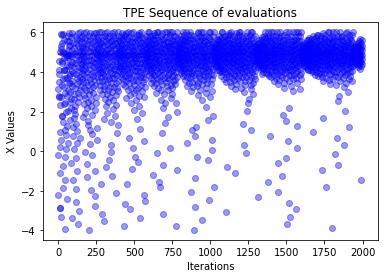

In [13]:
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.4);
plt.xlabel('Iterations')
plt.ylabel('X Values')
plt.title('TPE Sequence of evaluations')
plt.hlines(min_x, 0, 2000, linestyle ='--', colors = 'r');

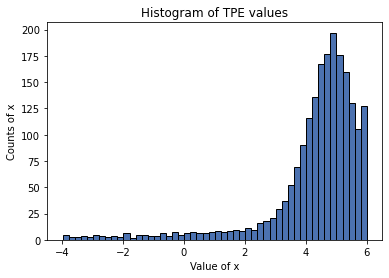

In [14]:
plt.hist(tpe_results['x'], bins=50, edgecolor = 'k')
plt.xlabel('Value of x')
plt.ylabel('Counts of x')
plt.title('Histogram of TPE values');

Best loss of -219.80120325347818 occured at iteration 859


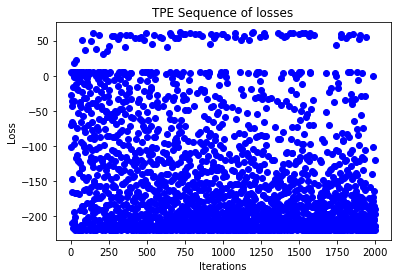

In [15]:
#sorting with best first loss

tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()
plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo');
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('TPE Sequence of losses');

print('Best loss of {} occured at iteration {}'.format(tpe_results['loss'][0],tpe_results['iteration'][0]))


# 4. 2 Results from Random

In [16]:
rand_results = pd.DataFrame({ 'loss' : [x['loss'] for x in rand_trials.results], 'iteration' : rand_trials.idxs_vals[0]['x'], 'x' : rand_trials.idxs_vals[1]['x']})

rand_results

,loss,iteration,x
0,-70.221046,0,3.159530
1,5.255827,1,-0.188930
2,-27.994579,2,-2.237837
3,-101.663418,3,3.488275
4,-42.851011,4,2.807139
...,...,...,...
1995,-41.026346,1995,-2.474012
1996,5.046348,1996,-0.035131
1997,-40.097291,1997,2.765570
1998,-11.125955,1998,2.163926


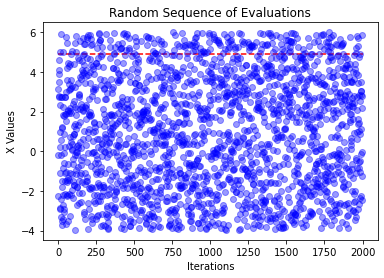

In [17]:
plt.plot(rand_results['iteration'], rand_results['x'], 'bo' , alpha = .4);
plt.xlabel('Iterations')
plt.ylabel('X Values')
plt.title('Random Sequence of Evaluations')
plt.hlines(min_x,0,2000,linestyle = '--', colors = 'r')

Best loss of -219.801203233421 occured at iteration 1713


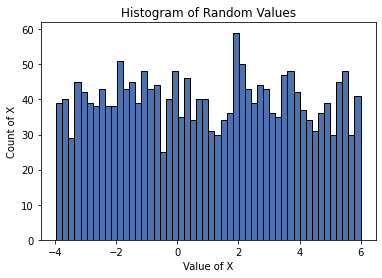

In [18]:
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()
plt.hist(rand_results['x'], bins=50,edgecolor = 'k')
plt.title('Histogram of Random Values')
plt.xlabel('Value of X')
plt.ylabel('Count of X')

print('Best loss of {} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

# 5. Domain space identification

Text(0, 0.5, 'Count of X')

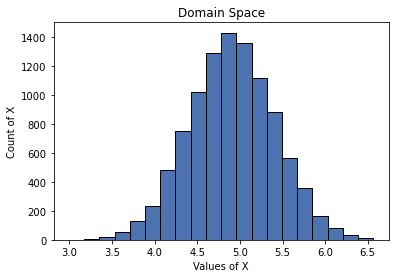

In [19]:
# taking a normally distributed space near the global minima

space = hp.normal('x', 4.9, 0.5)

samples = []

for _ in range(10000):
    samples.append(sample(space))

plt.hist(samples, bins = 20, edgecolor = 'k')
plt.title('Domain Space')
plt.xlabel('Values of X')
plt.ylabel('Count of X')

# 6. Building Loss and Status Metrics

In [20]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [21]:
def objective(x):
    """Objective function to minimize with smarter return"""
    
    #creating the polynomial object
    f = np.poly1d([ 1, -2, -28, 28, 12, -26,100])
    
    start = timer()
    loss = f(x) *0.05
    end = timer()
    
    time_elapsed = end-start
    
    results = {'loss' : loss, 'status' : STATUS_OK, 'x' : x, 'time': time_elapsed}
    
    return results

In [22]:
trials = Trials()

best = fmin(fn = objective,space = space, algo = tpe_algo , trials = trials, max_evals = 2000, rstate = np.random.RandomState(120))

results = trials.results

results[:2]

100%|██████████████████████████████████████████| 2000/2000 [00:11<00:00, 174.95trial/s, best loss: -219.80120395524256]


[{'loss': -189.3682041842684,
  'status': 'ok',
  'x': 5.312379584994148,
  'time': 3.0499999866151484e-05},
 {'loss': -219.325099632915,
  'status': 'ok',
  'x': 4.8166084516702705,
  'time': 1.7899999875226058e-05}]

In [23]:
#converting results into a dataframe

results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

#starting with the lowest loss on top

results_df = results_df.sort_values('loss', ascending = True)
results_df

,time,loss,x,iteration
956,0.000022,-219.801204,4.878152,956
1316,0.000024,-219.801204,4.878111,1316
402,0.000019,-219.801204,4.878189,402
914,0.000021,-219.801203,4.878064,914
1954,0.000027,-219.801203,4.878222,1954
...,...,...,...,...
44,0.000017,90.363527,6.043410,44
885,0.000019,103.236025,6.062224,885
510,0.000024,164.741515,6.145663,510
1670,0.000033,211.247139,6.202834,1670


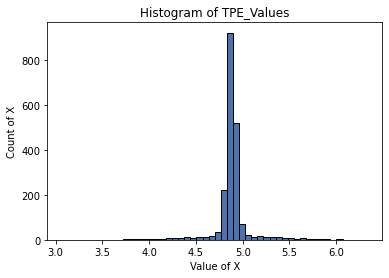

In [24]:
# histogram of tpe_values

plt.hist(results_df['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE_Values')
plt.xlabel('Value of X')
plt.ylabel('Count of X');

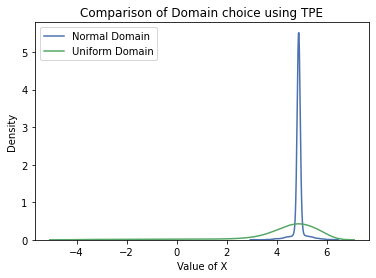

In [25]:
sns.kdeplot(results_df['x'], label = 'Normal Domain')
sns.kdeplot(tpe_results['x'], label = 'Uniform Domain')
plt.legend()
plt.xlabel('Value of X')
plt.ylabel('Density')
plt.title('Comparison of Domain choice using TPE');


In [26]:
print('The lowest value of the objective function {}, is found at x = {}, in {} iterations'.format(results_df['loss'].min(), 
                                                                                                   results_df.loc[results_df['loss'].idxmin()]['x'],
                                                                                                  results_df.loc[results_df['loss'].idxmin()]['iteration']))

#1713 for RANDOM and 956 of Tree Parzen estimator

The lowest value of the objective function -219.80120395524256, is found at x = 4.87815164674997, in 956.0 iterations
